# **Twitter Sentiment Polarity Analysis using Naive Bayes**


## Import Libraries

In [1]:
import re 
import sys 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from google.colab import drive
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif as MIC 
from sklearn.utils import shuffle 
from prettytable import PrettyTable 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
import random
from sklearn.manifold import TSNE 
import scipy.sparse 
import joblib 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Dataset


In [2]:
# from google.colab import files
# upload = files.upload()

In [ ]:
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d kazanova/sentiment140

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip sentiment140.zip

unzip:  cannot find or open sentiment140.zip, sentiment140.zip.zip or sentiment140.zip.ZIP.


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# dataframe = pd.read_csv('/content/gdrive/MyDrive/training.1600000.processed.noemoticon.csv',encoding ="ISO-8859-1",names=["target", "ids", "date", "flag", "user", "text"])
# dataframe.head()

In [5]:
dataframe = pd.read_csv('/content/gdrive/MyDrive/sentiment140Updated.csv',encoding ="ISO-8859-1",names=["target", "ids", "date", "flag", "user", "text"])
dataframe.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,4,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
len(dataframe)

1600000

In [7]:
dataframe = dataframe.loc[dataframe['target'].isin([0,4])]

In [8]:
len(dataframe)

1600000

In [9]:
dataframe = dataframe.drop(['ids', 'date', 'flag', 'user'], axis=1)
dataframe['target'] = [1 if target == 4 else target for target in dataframe['target']]

In [10]:
dataframe["target"].value_counts()

1    1220474
0     379526
Name: target, dtype: int64

In [11]:
dataframe = shuffle(dataframe)

In [12]:
dataframe.head(10)

,target,text
873700,1,BBQ with wife and friends... it`s gonna be a g...
1249886,1,"@IndigoLife Thank you, it's a recent snap!"
788348,1,"@tdwpband awe, i was supposed to go this year,..."
1098184,1,@sargedunn1 Yeah then you could send it to me...
1582584,1,"@gschan fortunately, I have. love the new ava..."
515931,0,lost the battle to @PeterBurrowes1 ! Alone in...
61530,1,Do you still think of me?? (I think of you)
892615,1,anyone wanna grab a coffee at westfield this m...
503403,0,Got be at work early in the morn...ugh
237734,1,@lulliecarole i dont know. and don't ask about...


## **Preprocessing**

### Stop Words

In [13]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")

In [14]:
stop_words[0:9] # Write to file 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you']

In [15]:
#dataframe["text"] = dataframe["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [16]:
tweets = list(dataframe["text"]) 
label = list(dataframe["target"])

In [17]:
# Remove tags and urls 
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
tagPattern       = '@[^\s]+'
# Also replacing three or more occurences of a letter with two occurences
repititionPattern   = r"(.)\1\1+"
repititionReplacePattern = r"\1\1"

def preprocess(tweets,stem=False):
  for i in range(len(tweets)): 
    tweet = tweets[i]
    tweet = tweet.lower()
    tweet = re.sub(urlPattern,'',tweet)
    tweet = re.sub(tagPattern,'', tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #Remove the #
    tweet = re.sub("[^a-zA-Z0-9]", " ", tweet)
    tweet = re.sub(repititionPattern,repititionReplacePattern, tweet)   
    words = []
    for word in tweet.split(): 
      if (word != " " and  word  not in stop_words):
        if stem:
          words.append(stemmer.stem(word))
        else:
          words.append(word)
    tweets[i] = " ".join(words)
  return tweets
   

### Stemming, remove URLs

In [18]:
performStemming = False
tweets = preprocess(tweets, performStemming)

In [19]:
tweets[0:9] # Write to file 

['bbq wife friends gonna great evening sure',
 'thank recent snap',
 'awe supposed go year sure',
 'yeah could send bit time squander lol send bank detail lol haa',
 'fortunately love new avatar green panda',
 'lost battle alone office moment others prepare 4 another big ebay day tomo',
 'still think think',
 'anyone wanna grab coffee westfield morning',
 'got work early morn ugh']

## **Feature extraction** (tf-idf vectorization)

In [ ]:
# Code logic 
# Imported libraries were used instead of this code 

# vocabulary = [] 
# count = 0
# for i in range(len(tweets)): 
#   for j in tweets[i].split(): 
#     if j not in vocabulary: 
#       vocabulary.append(j) 
#       count += 1 

# vectors = [[0 for i in range(count)] for i in range(len(tweets))]
# for i in range(len(tweets)): 
#   for j in range(count): 
#     vectors[i][j] = tweets[i].split().count(vocabulary[j]) 

In [20]:
vectorizerM = TfidfVectorizer() 

In [21]:
vectorizerB = CountVectorizer() # Use this for Bernoulli NB

In [22]:
vectorizerM.fit(tweets)  
vectorizerB.fit(tweets)

CountVectorizer()

In [23]:
A = vectorizerM.vocabulary_
j = 0
for i in A.items():
  if j>10:
    break
  j = j+1
  print(i)


('bbq', 27165)
('wife', 251140)
('friends', 88483)
('gonna', 95770)
('great', 97543)
('evening', 77811)
('sure', 220023)
('thank', 226306)
('recent', 187570)
('snap', 209421)
('awe', 22966)


In [24]:
len(vectorizerM.vocabulary_) 

260131

In [25]:
tweetsM = vectorizerM.transform(tweets) 
tweetsB = vectorizerB.transform(tweets)

In [26]:
tweetsM.shape

(1600000, 260131)

## **Train-Test Split**

In [27]:
tweetsTrainM, tweetsTestM, labelsTrain, labelsTest = train_test_split(tweetsM, label, test_size = 0.1, random_state=0)

In [28]:
tweetsTrainB, tweetsTestB, labelsTrain, labelsTest = train_test_split(tweetsB, label, test_size = 0.1, random_state=0)

In [29]:
tweetsTrainM.shape

(1440000, 260131)

## **Feature Selection**


### *Chi-Square*



In [30]:
chi2_features = SelectKBest(chi2,k=3000) 
X_train_chiM = chi2_features.fit_transform(tweetsTrainM,labelsTrain)
X_test_chiM = chi2_features.transform(tweetsTestM)

In [31]:
chi2_features = SelectKBest(chi2,k=3000) 
X_train_chiB = chi2_features.fit_transform(tweetsTrainB,labelsTrain)
X_test_chiB = chi2_features.transform(tweetsTestB)

In [32]:
X_train_chiM

<1440000x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 5265373 stored elements in Compressed Sparse Row format>

### *Mutual Information*

In [ ]:
# mi_score = MIC(tweetsTrain,labelsTrain)

In [ ]:
# avg_score = sum(mi_score)/len(mi_score)
# mi_score_selected_index = np.where(mi_score >avg_score)[0]
# X_train_mi = tweetsTrain[:,mi_score_selected_index]
# X_test_mi = tweetsTest[:,mi_score_selected_index]

## **Visualization** 
*(TSNE is very time-consuming)*

In [ ]:
tweets = X_test_chiM

In [ ]:
def plot_Tweet_Embeddings(tweets, subset, dimensions):

  # Shuffle indices too!
  indexes = [i for i in range(tweets.shape[0])]
  tweets, indexes = shuffle(tweets, indexes, random_state=0)

  emb = TSNE(n_components=dimensions).fit_transform(tweets[0:subset])

  x = emb[:subset, 0]
  y = emb[:subset, 1]
  if(dimensions ==3):
    z = emb[:subset, 2]
  colors = []
  i = 0

  for i in range(subset): 
    index = indexes[i]     
    if (dataframe.iat[index,0]==1):
      point_color = "green" # Positive Tweet
    else:
      point_color = "red" # Negative Tweet
    colors.append(point_color)

  plt.figure(figsize=(10,6),dpi=100)
  plt.title("Tweet Representation space visualization using TSNE")
  if(dimensions == 3):
    ax = plt.axes(projection='3d')
    ax.scatter(x, y, z,color= colors, linewidth=0.5);
  if(dimensions == 2):
    plt.scatter(x, y, color =colors)
  plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


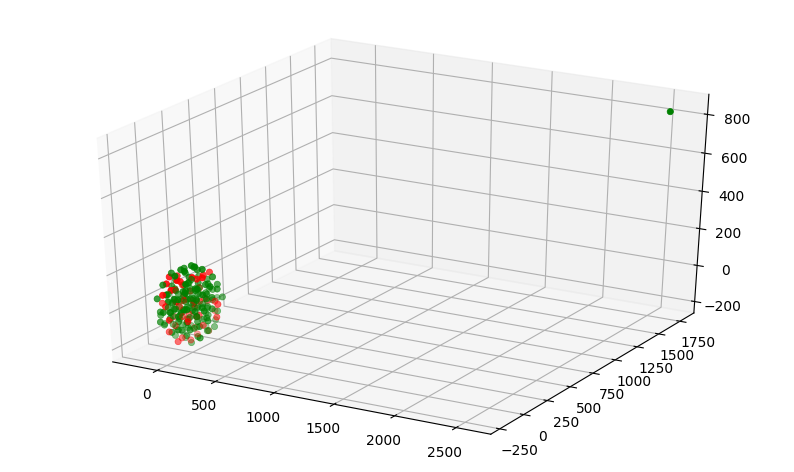

In [ ]:
#@title Visualize Tweet Representation Space { run: "auto" }
Num_tweets = 200 #@param {type:"slider", min:100, max:6000, step:100}
Dimensions = "3D Plot" #@param ["2D Plot", "3D Plot"]

d = 2
if(Dimensions == "2D Plot"):
  d = 2
elif(Dimensions == "3D Plot"):
  d = 3
plot_Tweet_Embeddings(tweetsM, subset= Num_tweets, dimensions=d)

## **Naive Bayes Classifier System**

### Multinomial NB

In [33]:
mBayesClassifier = MultinomialNB()

In [34]:
mBayesClassifier.fit(tweetsTrainM, labelsTrain)

MultinomialNB()

In [35]:
mBayesClassifier_chi = MultinomialNB()
mBayesClassifier_chi.fit(X_train_chiM, labelsTrain)

MultinomialNB()

### Bernoulli NB

In [36]:
bBayesClassifier = BernoulliNB(binarize = 1)

In [37]:
bBayesClassifier.fit(tweetsTrainB, labelsTrain)

BernoulliNB(binarize=1)

In [38]:
bBayesClassifier_chi = BernoulliNB(binarize = 1)
bBayesClassifier_chi.fit(X_train_chiB, labelsTrain)

BernoulliNB(binarize=1)

In [ ]:
# mBayesClassifier_mi = MultinomialNB()
# mBayesClassifier_mi.fit(X_train_mi, labelsTrain)

In [ ]:
# bBayesClassifier_mi = BernoulliNB(binarize = 1)
# bBayesClassifier_mi.fit(X_train_mi, labelsTrain)

## **Evaluation and Comparison of Results**

In [39]:
def precision(tp,fp):
  return tp / (tp + fp)

In [40]:
def recall(tp,fn):
  return tp / (tp + fn)

In [41]:
def fscore(p,r):
  return 2*p*r/(p+r)

In [42]:
def getAccuracy(labelsPred, labelsTest): 
  correct = 0 
  for i in range(len(labelsPred)): 
    if labelsPred[i] == labelsTest[i]: 
      correct += 1 
  return correct / len(labelsPred)

In [43]:
def printResults(labelsPred, labelsTest):
  tn, fp, fn, tp = confusion_matrix(labelsTest, labelsPred).ravel()
  table = PrettyTable(['', 'Actual Positive', 'Actual Negative'])
  table.add_row(['Predicted Positive', tp, fp])
  table.add_row(['Predicted Negative', fn, tn])
  p = precision(tp,fp)
  r = recall(tp,fn)
  f1 = fscore(p,r) 
  acc = getAccuracy(labelsPred, labelsTest)
  print("CONFUSION MATRIX:")
  print(table)
  print()
  print("EVALUATION METRICS:")
  print()
  print("Precision = %0.3f" %p)
  print("Recall = %0.3f" %r)
  print("F1 Score = %0.3f" %f1) 
  print("Accuracy = %0.3f" %acc) 


### Predictions

In [44]:
print(tweetsTestM[0])
print(type(tweetsTestM[0]))

  (0, 177449)	0.6642149327101898
  (0, 101396)	0.7475416531303108
<class 'scipy.sparse.csr.csr_matrix'>


In [45]:
labelsPredM = mBayesClassifier.predict(tweetsTestM)
labelsPredB = bBayesClassifier.predict(tweetsTestB)


In [46]:
labelsPredM_chi = mBayesClassifier_chi.predict(X_test_chiM)
labelsPredB_chi = bBayesClassifier_chi.predict(X_test_chiB)

In [ ]:
# labelsPredM_mi = mBayesClassifier_mi.predict(X_test_mi)
# labelsPredB_mi = bBayesClassifier_mi.predict(X_test_mi)

### **Multinomial NB**

In [47]:
printResults(labelsPredM, labelsTest)

CONFUSION MATRIX:
+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |      121369     |      26370      |
| Predicted Negative |       687       |      11574      |
+--------------------+-----------------+-----------------+

EVALUATION METRICS:

Precision = 0.822
Recall = 0.994
F1 Score = 0.900
Accuracy = 0.831


#### *Multinomial NB + Chi-Square*

In [48]:
printResults(labelsPredM_chi, labelsTest)

CONFUSION MATRIX:
+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |      121588     |      25053      |
| Predicted Negative |       468       |      12891      |
+--------------------+-----------------+-----------------+

EVALUATION METRICS:

Precision = 0.829
Recall = 0.996
F1 Score = 0.905
Accuracy = 0.840


#### *Multinomial NB + MI*

In [49]:
# tn_mi, fp_mi, fn_mi, tp_mi = confusion_matrix(labelsTest, labelsPredM_mi.ravel()

In [ ]:
# p_mi = precision(tp_mi,fp_mi)
# r_mi = recall(tp_mi,fn_mi)
# fscore_mi = fscore(p_mi,r_mi)
# p_mi,r_mi,fscore_mi

### **Bernoulli NB**

In [50]:
printResults(labelsPredB, labelsTest)

CONFUSION MATRIX:
+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |      121737     |      36958      |
| Predicted Negative |       319       |       986       |
+--------------------+-----------------+-----------------+

EVALUATION METRICS:

Precision = 0.767
Recall = 0.997
F1 Score = 0.867
Accuracy = 0.767


#### *Bernoulli NB + Chi-Square*

In [51]:
printResults(labelsPredB_chi, labelsTest)

CONFUSION MATRIX:
+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |      121780     |      36888      |
| Predicted Negative |       276       |       1056      |
+--------------------+-----------------+-----------------+

EVALUATION METRICS:

Precision = 0.768
Recall = 0.998
F1 Score = 0.868
Accuracy = 0.768


#### *Bernoulli NB + MI*

In [ ]:
# tn_mi, fp_mi, fn_mi, tp_mi = confusion_matrix(labelsTest, labelsPredM_mi.ravel()
# p_mi = precision(tp_mi,fp_mi)
# r_mi = recall(tp_mi,fn_mi)
# fscore_mi = fscore(p_mi,r_mi)
# p_mi,r_mi,fscore_mi

## **Save Intermediate Results**

In [52]:
# Save modified shuffled dataframe to csv
dataframe.to_csv('/content/gdrive/MyDrive/sentimentModifiedShuffled.csv', index = False, header = False, encoding ="ISO-8859-1")

In [53]:
# Save stop words list
f = open('/content/gdrive/MyDrive/stopWords.txt', "w") 
for i in stop_words: 
  f.write("%s\n" % i)
f.close()

In [54]:
# Save processed tweets 
f = open('/content/gdrive/MyDrive/processedTweets.txt', "w") 
for i in tweets: 
  f.write("%s\n" % i)
f.close()

In [55]:
# Save vocabulary 
f = open('/content/gdrive/MyDrive/vocabulary.txt', "w") 
A = vectorizerB.vocabulary_
for i in A.items(): 
  f.write("%s %d \n" %(i[0], i[1]))
f.close()

In [56]:
# Save vectorized tweets (tfidf and count)
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsM.npz', tweetsM) 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsB.npz', tweetsB) 

# To be loaded using tweets = scipy.sparse.load_npz('/content/gdrive/MyDrive/tweetsM.npz') or 
# tweets = scipy.sparse.load_npz('/content/gdrive/MyDrive/tweetsB.npz') 
# and displayed using tweets.toarray() 
# but due to the size of the data, colab crashes 

In [57]:
# Save train and test features 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTrainM.npz', tweetsTrainM) 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTestM.npz', tweetsTestM) 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTrainB.npz', tweetsTrainB) 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTestB.npz', tweetsTestB) 

In [58]:
# Save train and test labels 
f = open('/content/gdrive/MyDrive/labelsTrain.txt', "w") 
for i in labelsTrain: 
  f.write("%d\n" % i)
f.close() 

f = open('/content/gdrive/MyDrive/labelsTest.txt', "w") 
for i in labelsTest: 
  f.write("%d\n" % i)
f.close() 

In [59]:
# Save train and test features after chi-square feature selection 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTrainMChi.npz', X_train_chiM) 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTestMChi.npz', X_test_chiM) 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTrainBChi.npz', X_train_chiB) 
scipy.sparse.save_npz('/content/gdrive/MyDrive/tweetsTestBChi.npz', X_test_chiB) 

In [70]:
# Save trained classifiers 
joblib.dump(mBayesClassifier, "/content/gdrive/MyDrive/mBayes.joblib") 
joblib.dump(mBayesClassifier_chi, "/content/gdrive/MyDrive/mBayesChi.joblib") 
joblib.dump(bBayesClassifier, "/content/gdrive/MyDrive/bBayes.joblib") 
joblib.dump(bBayesClassifier_chi, "/content/gdrive/MyDrive/bBayesChi.joblib")

['/content/gdrive/MyDrive/bBayesChi.joblib']

In [ ]:
# f = open('/content/gdrive/MyDrive/mBayesEval.txt', 'w') 
# f.close()
# sys.stdout = open('/content/gdrive/MyDrive/mBayesEval.txt', "w")
# printResults([0, 0, 1, 1], [1, 1, 0, 1]) 
# sys.stdout.close()

# **Prediction Tool**

In [71]:
# Load previously trained classifiers 
mBayesL = joblib.load("/content/gdrive/MyDrive/mBayes.joblib") 
mBayesChiL = joblib.load("/content/gdrive/MyDrive/mBayesChi.joblib") 
bBayesL = joblib.load("/content/gdrive/MyDrive/bBayes.joblib") 
bBayesChiL = joblib.load("/content/gdrive/MyDrive/bBayesChi.joblib") 

In [79]:
#@title Tweet Something! { run: "auto", vertical-output: true }
Tweet = "@abc I love dogs" #@param {type:"string"}
Naive_Bayes_Model = "Bernoulli NB" #@param ["Multinomial NB", "Bernoulli NB"]
Feature_Selection = "Chi-Square" #@param ["Chi-Square", "None"]

label = -1

tweet = preprocess([Tweet], stem = False)
if (Naive_Bayes_Model == "Multinomial NB"): 
  vector = vectorizerM.transform(tweet) 
else: 
  vector = vectorizerB.transform(tweet) 
print("The stemmed tweet: (", tweet, ") is a...")
print()

# Chi-Squared
if(Feature_Selection == "Chi-Square"):
  vector_reduced = chi2_features.transform(vector)
  if(Naive_Bayes_Model == "Bernoulli NB"):
    label = bBayesChiL.predict(vector_reduced)
  elif(Naive_Bayes_Model == "Multinomial NB"):
    label = mBayesChiL.predict(vector_reduced)

# No Feature Selection
if(Feature_Selection == "None"):
  if(Naive_Bayes_Model == "Bernoulli NB"):
    label = bBayesL.predict(vector)
  elif(Naive_Bayes_Model == "Multinomial NB"):
    label = mBayesL.predict(vector)

# Print Output
if label == 1:
  print("POSITIVE Tweet! :)")
elif label == 0:
  print("NEGATIVE Tweet :(")
else:
  print("Oops! Something went wrong...")

The stemmed tweet: ( ['love'] ) is a...

POSITIVE Tweet! :)
